In [1]:
import pandas as pd
import numpy as np
import sqlite3
import json
import matplotlib.pyplot as plt

#### prepare the TFD/E results

In [2]:
# load the results
EXPERIMENT_DIR = '/Users/darylwilding-mcbride/Downloads/experiments/YHE-R'
RESULTS_DB_NAME = '{}/summarised-results/results.sqlite'.format(EXPERIMENT_DIR)
db_conn = sqlite3.connect(RESULTS_DB_NAME)
results_df = pd.read_sql_query("select * from sequences", db_conn)
db_conn.close()

In [3]:
len(results_df)

29553

In [4]:
# convert the identifications from JSON to Python objects
results_df['identifications_d'] = results_df.apply(lambda row: json.loads(row.identifications), axis=1)

In [5]:
# separate some key metrics into separate columns
results_df['id_perc_q_value'] = results_df.apply(lambda row: row.identifications_d['perc_q_value'], axis=1)
results_df['id_count_all_runs'] = results_df.apply(lambda row: len(row.identifications_d['run_names']), axis=1)
results_df['id_count_human_only_runs'] = results_df.apply(lambda row: sum('YHE010' in s for s in row.identifications_d['run_names']), axis=1)

In [6]:
# remove the results that couldn't be extracted or were not classified as a target
results_df = results_df[results_df.extractions.notnull()].copy()

In [7]:
# convert from JSON to Python objects
results_df['extractions_l'] = results_df.apply(lambda row: json.loads(row.extractions), axis=1)

In [8]:
# separate some key metrics into separate columns
results_df['ext_count_all_runs'] = results_df.apply(lambda row: len(row.extractions_l), axis=1)
results_df['ext_count_human_only_runs'] = results_df.apply(lambda row: sum('YHE010' in s['run_name'] for s in row.extractions_l), axis=1)

In [9]:
results_df.sample(n=3)

,sequence,charge,human,identifications,extractions,identifications_d,id_perc_q_value,id_count_all_runs,id_count_human_only_runs,extractions_l,ext_count_all_runs,ext_count_human_only_runs
7814,FGAQNESLLPSILVLLQR,2,1,"{""perc_q_value"": 1.9514534e-05, ""run_names"": [...","[{""run_name"": ""YHE114_06_Slot1-1_1_3013"", ""pro...","{'perc_q_value': 1.9514534e-05, 'run_names': [...",0.000020,7,0,"[{'run_name': 'YHE114_06_Slot1-1_1_3013', 'pro...",26,7
16023,LQDSFASETNLDFR,2,1,"{""perc_q_value"": 2.9439299e-06, ""run_names"": [...","[{""run_name"": ""YHE114_11_Slot1-1_1_3043"", ""pro...","{'perc_q_value': 2.9439299e-06, 'run_names': [...",0.000003,5,1,"[{'run_name': 'YHE114_11_Slot1-1_1_3043', 'pro...",31,10
3174,DDNLVVLHDHYLDR,2,0,"{""perc_q_value"": 2.9439299e-06, ""run_names"": [...","[{""run_name"": ""YHE114_11_Slot1-1_1_3043"", ""pro...","{'perc_q_value': 2.9439299e-06, 'run_names': [...",0.000003,7,0,"[{'run_name': 'YHE114_11_Slot1-1_1_3043', 'pro...",30,9


In [13]:
# count the number of unique peptide identifications in each run
counts_d = {}
for row in results_df.itertuples():
    for run_name in row.identifications_d['run_names']:
        if run_name not in counts_d:
            counts_d[run_name] = 0
        counts_d[run_name] += 1

In [71]:
sorted_counts_l = []
for k in sorted(counts_d.keys()):
    short_run_name = k.split('_Slot')[0]
    sorted_counts_l.append((short_run_name, counts_d[k]))
sorted_counts_df = pd.DataFrame(sorted_counts_l, columns=['run_name','count'])

#### prepare the MaxQuant results

In [61]:
mq_results_df = pd.read_csv('/Users/darylwilding-mcbride/Downloads/evidence-YHE-R-6-oct.txt', sep='\\t', engine='python')

In [62]:
# remove decoys, which are indicated by a '+' in the Reverse column, and features with no intensity
mq_results_df = mq_results_df[pd.isna(mq_results_df.Reverse) & (mq_results_df.Intensity > 0)]

In [63]:
# definition of uniqueness in MaxQuant output with MBR on
unique_peptide_key = ['Sequence','Modifications','Charge']

In [65]:
# count the number of unique peptide identifications in each run
mq_counts_d = {}
for group_name,group_df in mq_results_df.groupby(unique_peptide_key, as_index=False):
    df = group_df[(group_df.Type == 'TIMS-MULTI-MSMS')]
    for run_name in df['Raw file'].unique():
        if run_name not in mq_counts_d:
            mq_counts_d[run_name] = 0
        mq_counts_d[run_name] += 1

In [73]:
mq_sorted_counts_l = []
for k in sorted(mq_counts_d.keys()):
    short_run_name = k.split('_Slot')[0]
    mq_sorted_counts_l.append((short_run_name, mq_counts_d[k]))
mq_sorted_counts_df = pd.DataFrame(mq_sorted_counts_l, columns=['run_name','count'])

#### plot the results

In [80]:
merged_df = pd.merge(sorted_counts_df, mq_sorted_counts_df, how='outer', left_on=['run_name'], right_on=['run_name'], suffixes=['_tfd_e','_mq'])
merged_df.index = merged_df.run_name

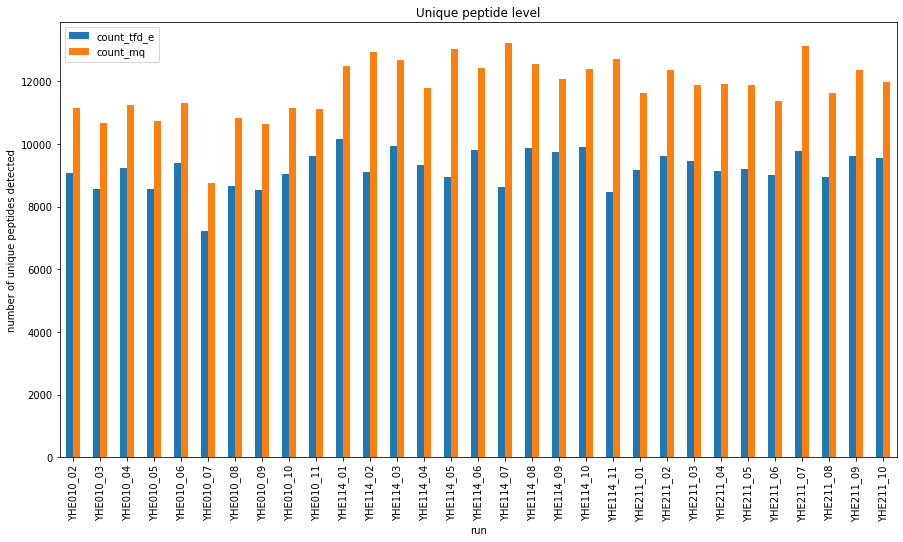

In [82]:
merged_df.plot(kind='bar', figsize=(15,8))
_ = plt.title("Unique peptide level")
_ = plt.xlabel("run")
_ = plt.ylabel("number of unique peptides detected")